In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path

from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import QED
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

from tqdm.auto import tqdm

from molskill.scorer import MolSkillScorer

from matplotlib import pyplot as plt
%matplotlib inline

[2024-12-20 20:26:15,454] [INFO] [standardization.py:33:get_population_moments] Standardization moments not found. Downloading from remote...


In [2]:
scorer = MolSkillScorer()

[2024-12-20 20:26:16,587] [INFO] [scorer.py:52:__init__] Model not specified. Using default from /home/klgx638/Projects/molskill/models/default/checkpoints/last.ckpt.


Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../molskill/models/default/checkpoints/last.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/klgx638/miniconda3/envs/py39molskill/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [3]:
def check_pains(data: pd.DataFrame, smiles_col = "smiles"):
    # add ROMol column
    PandasTools.AddMoleculeColumnToFrame(data, smilesCol=smiles_col)
    # initialize filter
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog(params)
    # search for PAINS
    matches = []
    clean = []
    for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        molecule = Chem.MolFromSmiles(row[smiles_col])
        entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
        if entry is not None:
            # store PAINS information
            matches.append(
                {
                    "chembl_id": row.index,
                    "rdkit_molecule": molecule,
                    "pains": entry.GetDescription().capitalize(),
                }
            )
        else:
            # collect indices of molecules without PAINS
            clean.append(index)
    
    matches = pd.DataFrame(matches)
    data = data.loc[clean]  # keep molecules without PAINS

    return len(matches), len(data) #number of compounds with PAINS, number of compounds without PAINS

In [4]:
#calculate QED scores and MolSkill scores and also presence of PAINS

In [5]:
#check how the csv file looks like
original_fluc = pd.read_csv("trained_dataset/fluc/random/rep1/selected_1.csv")
original_fluc.head()

,Agent,Prior,Target,Score,SMILES,SMILES_state,interference,interference (raw),Molecular weight,Molecular weight (raw),step
0,20.3005,22.4352,94.5635,0.914052,COc1ccc(Nc2ccn3ncc(-c4ccccc4)c3n2)cc1,1,0.89375,0.8938,0.999978,316.364,208
1,28.5446,30.0483,77.0221,0.836488,C[S+]([O-])c1cnc2ccccc2c1C(=O)c1ccncc1,1,0.80000,0.8000,0.999860,296.351,130
2,25.3267,26.0270,58.3240,0.658992,Cc1cc2cccnc2n1CCNC(=O)c1cccc(Cl)c1,1,0.59375,0.5938,0.999972,313.788,223
3,23.4570,24.8875,88.8259,0.888386,Nc1ccc(-c2nc3cnc(-c4ccncc4)cc3s2)cc1,1,0.86250,0.8625,0.999933,304.378,164
4,35.8452,35.9736,-30.3996,0.043547,COc1cc(OC)c(OC)cc1CN1CCN(C(=O)CCCOc2ccc3ncnc(N...,1,0.50625,0.5062,0.000002,640.568,12


In [6]:
#from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter

def get_scaffold(molecule):
    """
    Extracts the Bemis-Murcko scaffold from an RDKit molecule.
    Returns None if the scaffold cannot be extracted.
    """
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(molecule)
        return Chem.MolToSmiles(scaffold)
    except Exception as e:
        return None

def scaffold_diversity(molecule_list):
    """
    Calculates the scaffold diversity by counting the unique scaffolds in a list of RDKit molecules.
    
    Parameters:
    - molecule_list: list of RDKit molecules
    
    Returns:
    - diversity_score: float, fraction of unique scaffolds over total molecules
    - unique_scaffolds: set of unique scaffold SMILES
    """
    scaffolds = [get_scaffold(mol) for mol in molecule_list]
    scaffolds = [s for s in scaffolds if s is not None]  # Remove None values
    
    # Count unique scaffolds
    unique_scaffolds = set(scaffolds)
    total_molecules = len(scaffolds)
    
    if total_molecules == 0:
        return 0.0, unique_scaffolds
    
    # Scaffold diversity score: Fraction of unique scaffolds
    diversity_score = len(unique_scaffolds) / total_molecules
    return diversity_score, unique_scaffolds

# Example usage
if __name__ == "__main__":
    smiles_list = original_fluc.SMILES.tolist()  # Example SMILES strings
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]  # Convert to RDKit molecules
    
    diversity_score, unique_scaffolds = scaffold_diversity(molecules)
    print(f"Scaffold Diversity Score: {diversity_score}")
    #print(f"Unique Scaffolds: {unique_scaffolds}")


Scaffold Diversity Score: 0.948


In [7]:
human_analysis = pickle.load(open("human_analysis.pkl", "rb"))

In [8]:
def plot_metric(metric, sampling, task):
    all_metric_rep = []
    for k in range(1,11):
        all_metric_iter = []
        for i in range(1,6):
            if metric != "unique_scaffolds":
                all_metric_iter.append(human_analysis[task][sampling][i][k][metric])
            else:
                all_metric_iter.append(len(human_analysis[task][sampling][i][k][metric]))
        all_metric_rep.append(all_metric_iter)  # Collect all values for KDE
    return all_metric_rep

In [10]:
task = "redox"
metric = "qed"

#for task in ["fluc", "nluc", "thiol", "redox"]:
for sampling in ["random", "greedy", "epig", "epigskill", "greedyskill"]:
    all_metric_rep = plot_metric(metric, sampling, task)
    all_metric_rep = [np.mean(human_analysis[task]["original"][metric]).item()] + all_metric_rep
    plt.plot(np.arange(1,12), [np.mean(v) for v in all_metric_rep], label=sampling)
    plt.fill_between(np.arange(1,12), [np.mean(v) - np.std(v) for v in all_metric_rep], [np.mean(v) + np.std(v) for v in all_metric_rep], alpha=0.1)
    #plt.axhline(y=np.mean(human_analysis[task]["original"][metric]).item(), color="red")
    plt.legend()

NameError: name 'plot_metric' is not defined

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

task = "redox"
metric = "qed"

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot for each sampling method
for sampling in ["random", "greedy", "epig", "epigskill", "greedyskill"]:
    all_metric_rep = plot_metric(metric, sampling, task)
    sns.kdeplot([np.mean(v).item() for v in all_metric_rep], label=sampling, fill=True, alpha=0.3)
    
# Optionally, you can add a vertical line for the mean QED of the original set
original_mean = np.mean(human_analysis[task]["original"][metric]).item()
plt.axvline(original_mean, color="red", linestyle="--", label="Original Mean QED")

# Add labels and legend
plt.xlabel("QED")
plt.ylabel("Density")
plt.title(f"QED Distribution by Sampling Strategy for Task: {task}")
plt.legend()
plt.show()


NameError: name 'plot_metric' is not defined

<Figure size 1000x600 with 0 Axes>

In [12]:
task = "fluc"
sampling = "random"
metric = "qed"

data = {}
for k in np.arange(1,6):
    data[k.item()] = {}
    for j in np.arange(1,11):
        data[k][j.item()] = human_analysis[task][sampling][k][j][metric]

iteration_values = {}
for j in np.arange(1,11):
    iteration_values[j.item()] = []

for rep in data.values():
    for iteration, values in rep.items():
        iteration_values[iteration].extend(values)

# Plot KDE for each iteration using values across repetitions
plt.figure(figsize=(12, 8))

for iteration, values in iteration_values.items():
    sns.kdeplot(values, fill=True, label=f"Iteration {iteration}")

original_mean = np.nanmean(human_analysis[task]["original"][metric]).item()
plt.axvline(original_mean, color="red", linestyle="--", label=f"Initial mean {metric}")

plt.xlabel(metric)
plt.ylabel("Density")
plt.title(f"{metric} score distribution, dataset: {task}, sampling strategy: {sampling}")
plt.legend()
plt.show()

NameError: name 'human_analysis' is not defined

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Define parameters
task = "fluc"
metric = "molskill"
sampling_strategies = ["random", "greedy", "epig", "greedyskill", "epigskill"]
sampling_colors = {"random": "#808080", "greedy": "#ee82ee", "epig": "#FFA500", 
                   "molskill": "#0000ff", "greedyskill": "#7741f7", "epigskill": "#805380"}

# Retrieve initial distribution values for statistical comparison
initial_values = human_analysis[task]["original"][metric]

# Create a figure with 10 subplots (one per iteration)
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True, sharex=True)
axes = axes.flatten()  # Flatten to easily iterate over subplots

# Iterate over each iteration (1 through 10)
for iteration in range(1, 11):
    ax = axes[iteration - 1]
    
    # Plot KDE for each sampling strategy on the current iteration subplot
    for sampling in sampling_strategies:
        # Gather the data for the current sampling strategy and iteration
        data = []
        for k in np.arange(1, 6):
            values = human_analysis[task][sampling][k][iteration][metric]
            data.extend(values)
        
        # Perform a two-sample t-test with the initial distribution
        t_stat, p_value = ttest_ind(data, initial_values, nan_policy='omit')
        
        # Determine statistical significance
        significance = ""
        if p_value < 0.01:
            significance = "(**)"
        elif p_value < 0.05:
            significance = "(*)"
        
        # Update label to include significance marker
        label = f"{sampling} {significance}"
        
        # Plot KDE for the sampling strategy in the current subplot
        sns.kdeplot(data, fill=True, label=label, color=sampling_colors[sampling], alpha=0.1, ax=ax)
    
    # Plot a vertical line for the initial mean across all sampling strategies
    original_mean = np.nanmean(initial_values).item()
    ax.axvline(original_mean, color="red", linestyle="--", label="Initial mean")
    
    # Customize subplot
    ax.set_title(f"Iteration {iteration}", fontsize=18)
    ax.set_xlabel(f"{metric} score", fontsize=18)
    if iteration == 1 or iteration == 6:
        ax.set_ylabel("Density", fontsize=18)

    # Add a legend to the first subplot only to avoid repetition
    ax.legend(loc="upper right")

# Set main title and show plot
plt.suptitle(f"Dataset: {task}, Metric: {metric} score", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save the figure with high DPI
#plt.savefig(f"{metric}_score_distribution_{task}.png", dpi=300, format="png")
plt.show()


NameError: name 'human_analysis' is not defined

In [9]:
tasks = ["fluc", "nluc", "thiol", "redox"]
tasks_labels = {"fluc": "FI", "nluc": "NI", "thiol": "TR", "redox": "RR"}
strategies = ["random", "greedy", "epig", "greedyskill", "epigskill"]
strategies_labels = {"random": "Random", "greedy": "Greedy", "epig": "EPIG", "greedyskill": "GreedySkill", "epigskill": "EPIGSkill"}
metrics_labels = {"qed": "QED", "molskill": "MolSkill"}

/tmp/ipykernel_20738/1284046084.py:72: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),


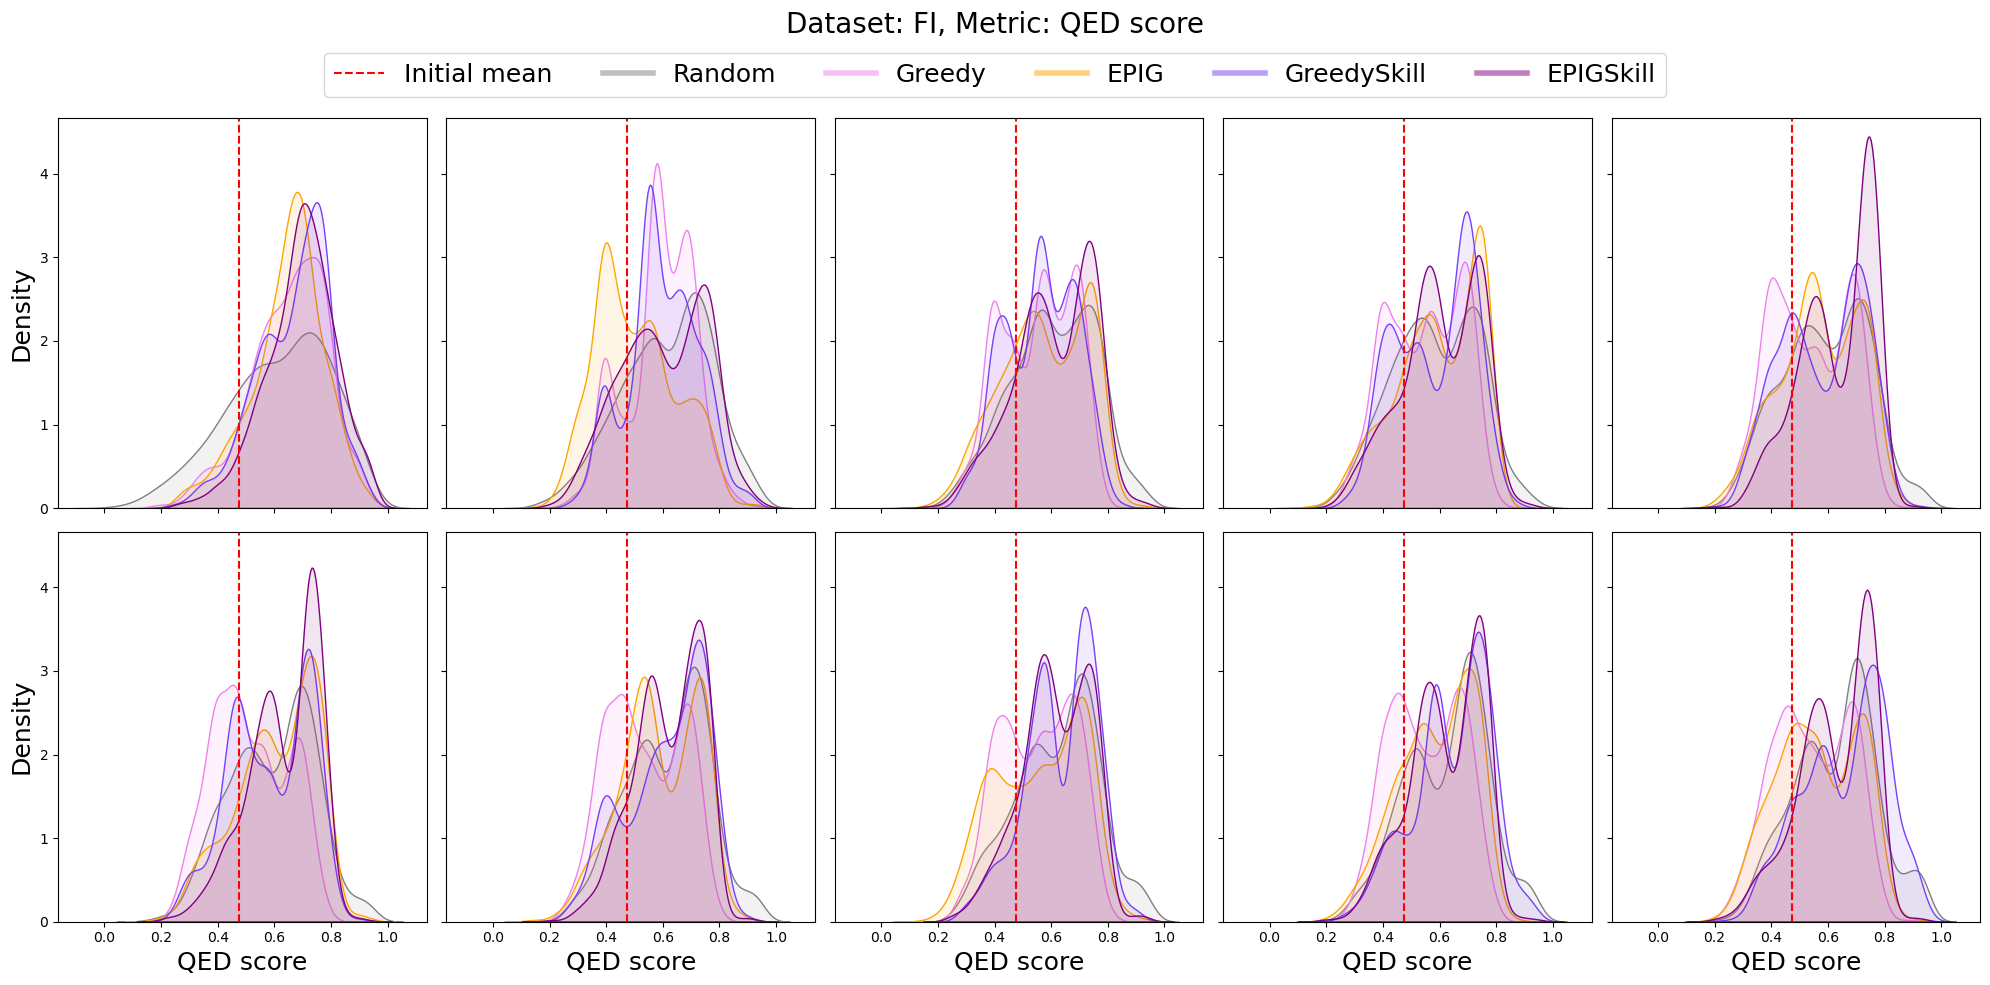

/tmp/ipykernel_20738/1284046084.py:72: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),


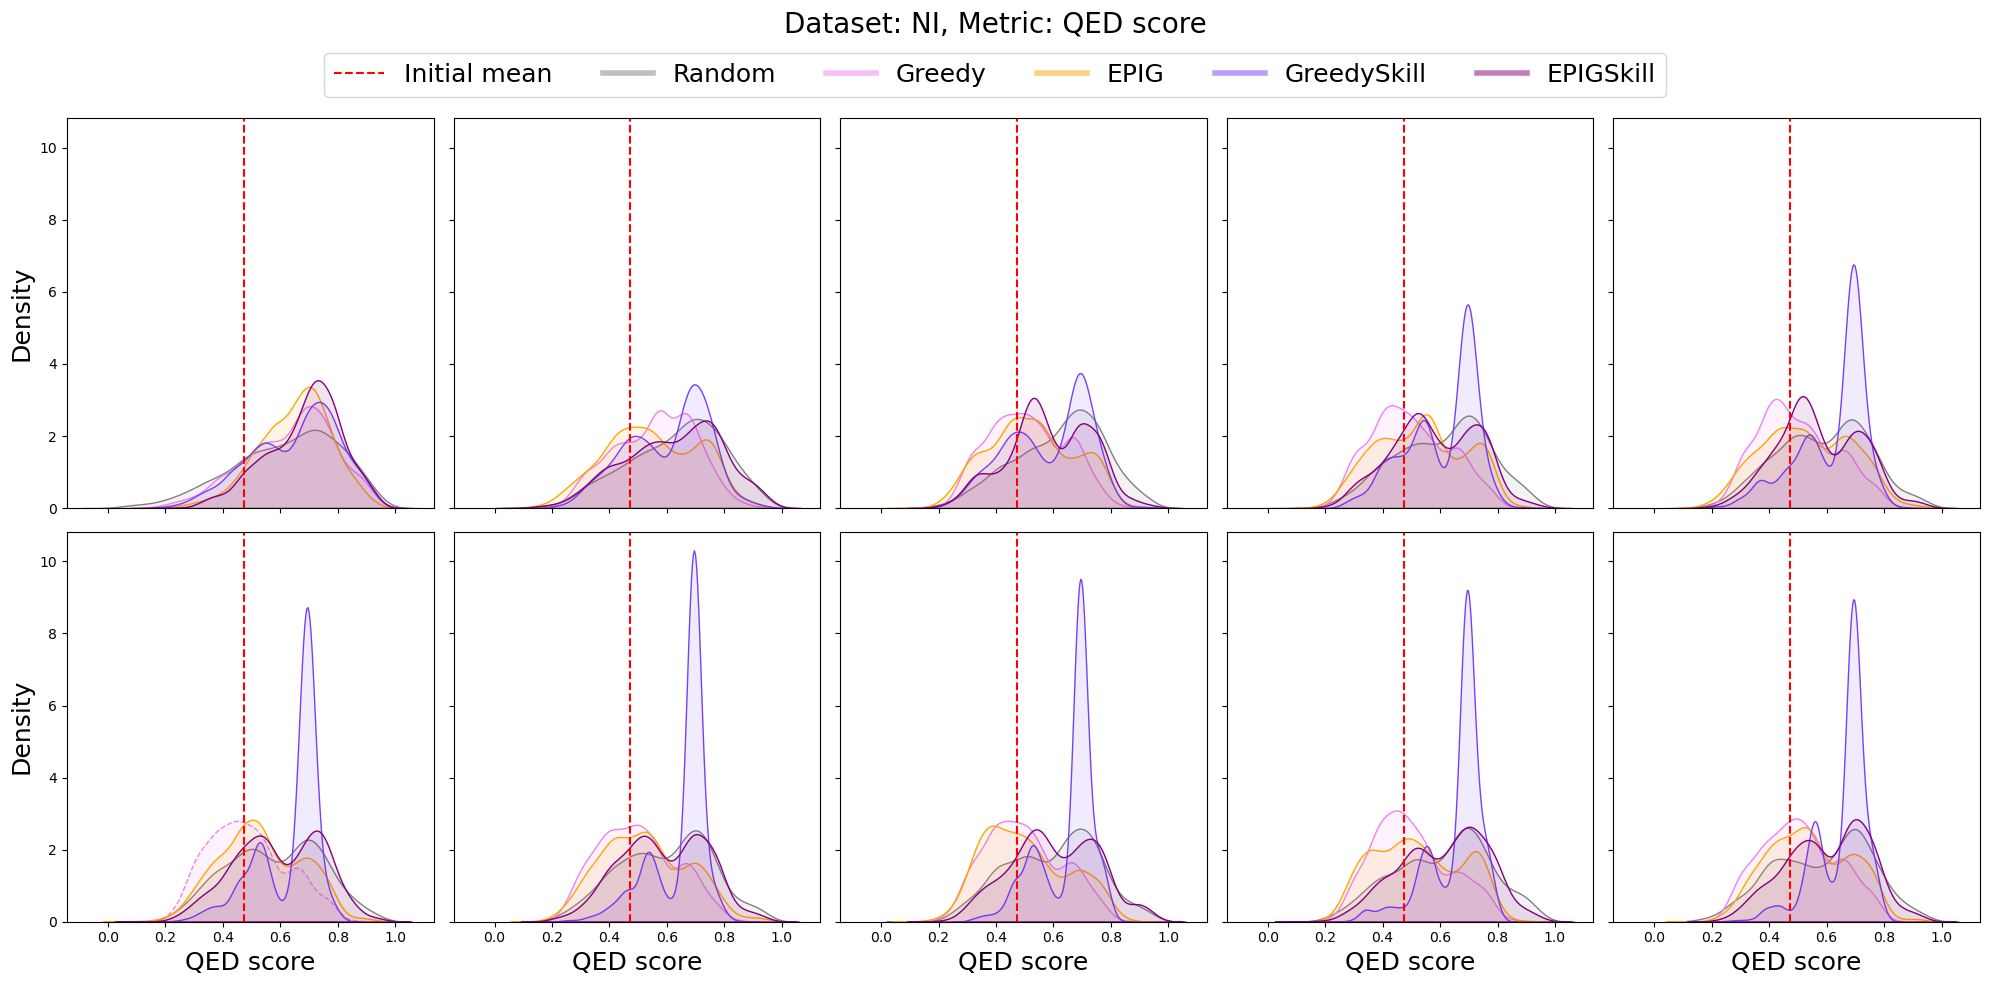

/tmp/ipykernel_20738/1284046084.py:72: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),


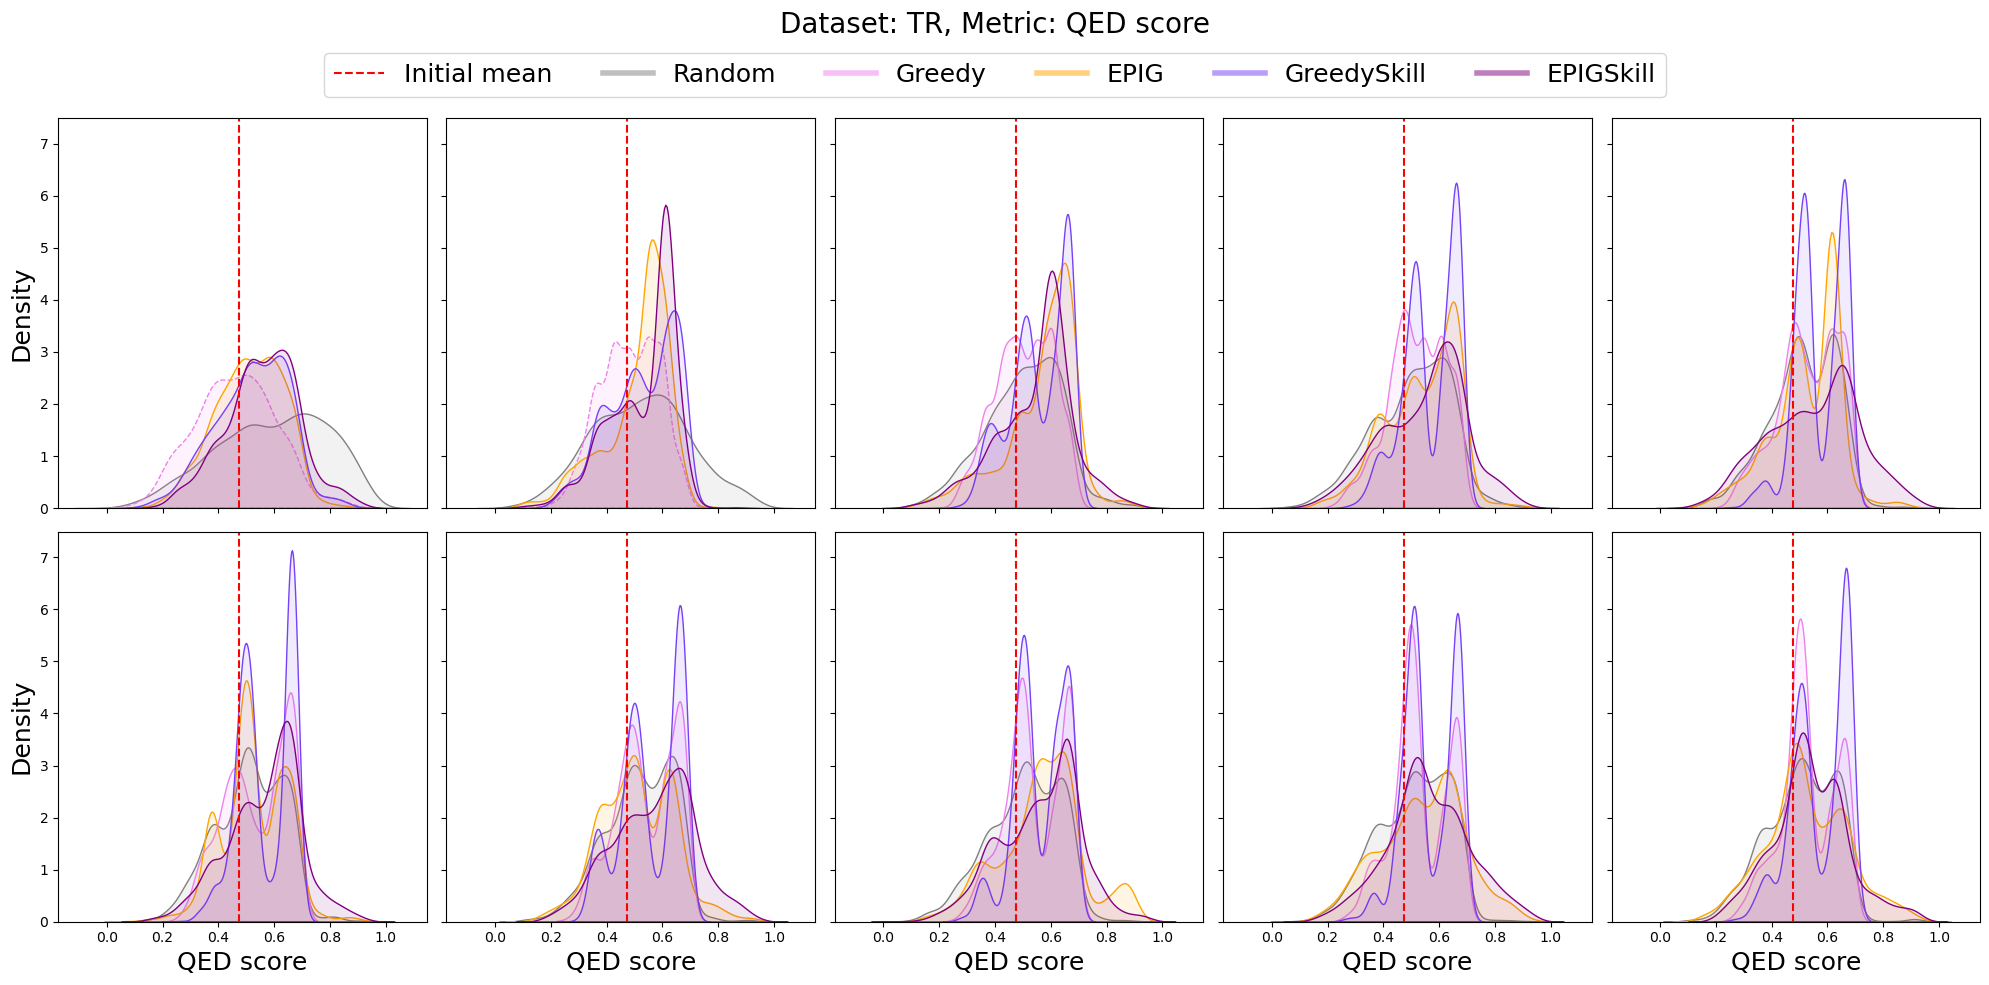

/tmp/ipykernel_20738/1284046084.py:72: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),


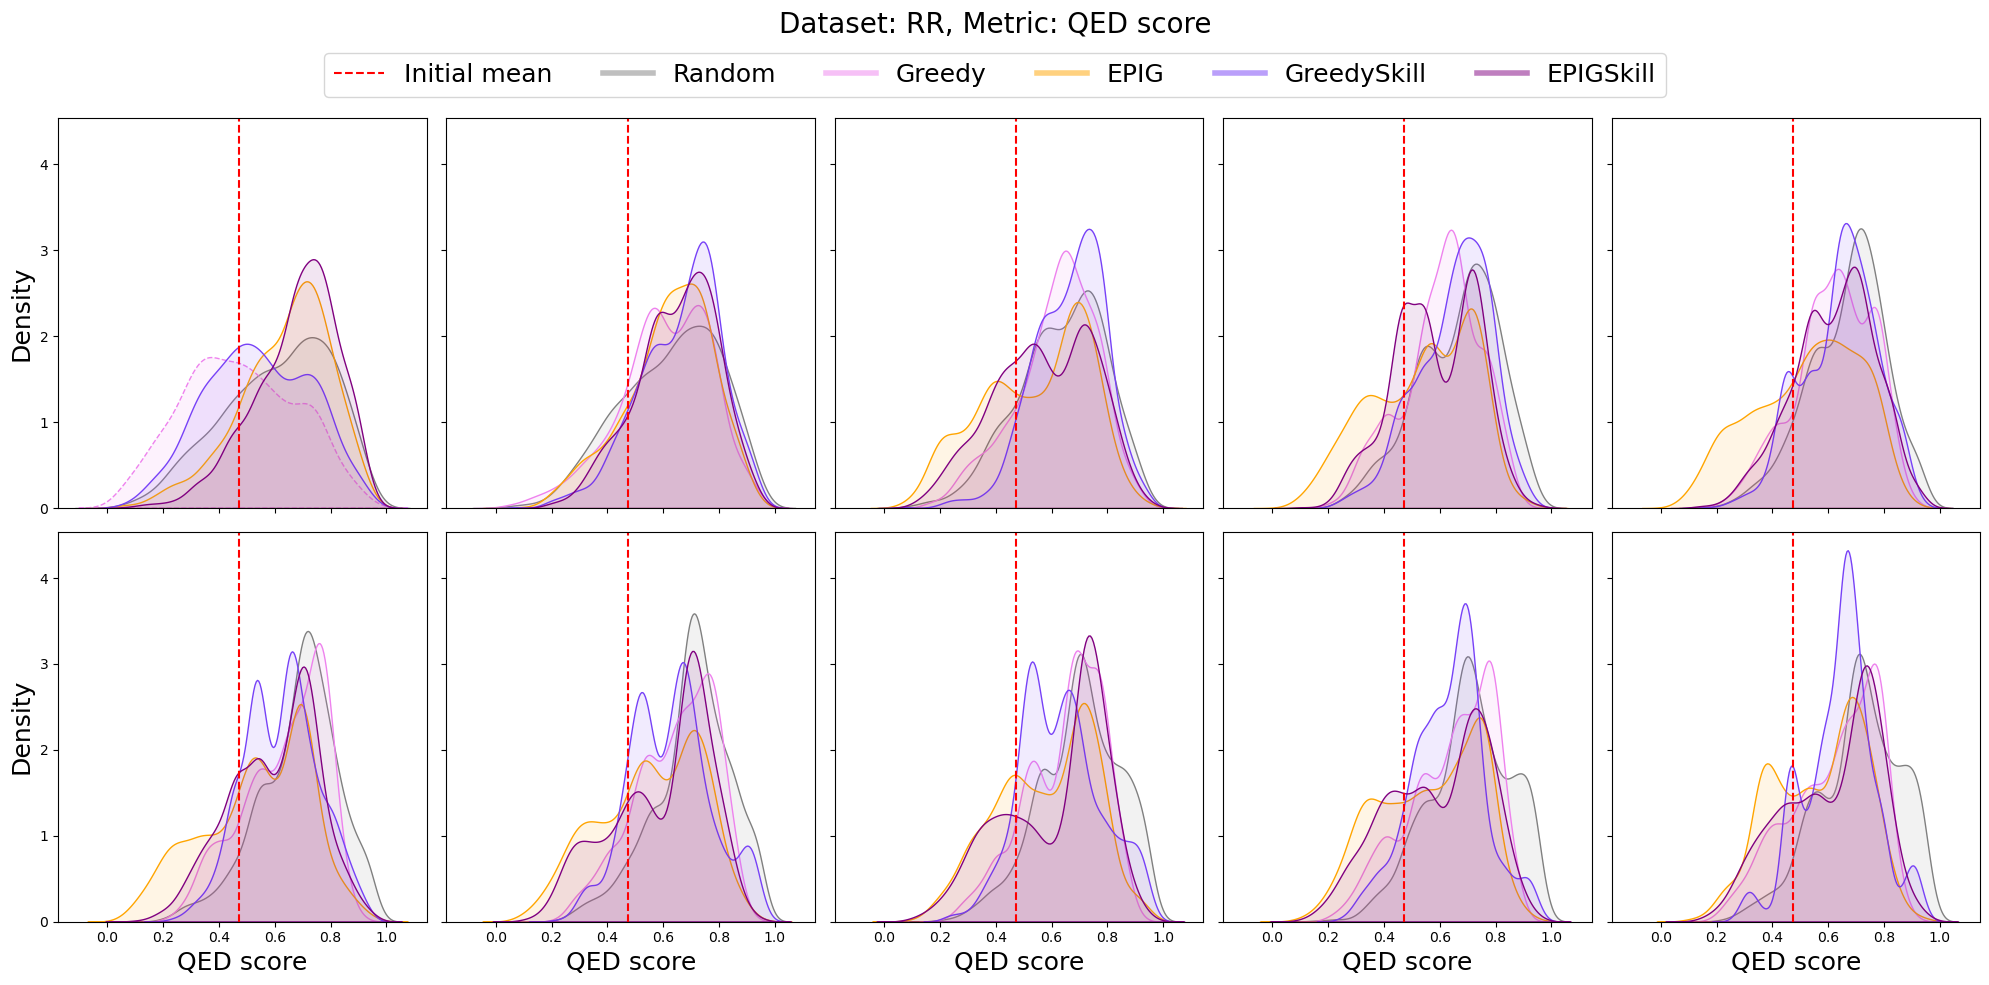

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

for task in tasks:
    # Define parameters
    #task = "thiol"
    metric = "qed"
    sampling_strategies = ["random", "greedy", "epig", "greedyskill", "epigskill"]
    sampling_colors = {
        "random": "#808080", 
        "greedy": "#ee82ee", 
        "epig": "#FFA500", 
        #"molskill": "#0000ff", 
        "greedyskill": "#7741f7", 
        "epigskill": "purple"
    }
    
    # Retrieve initial distribution values for statistical comparison
    initial_values = human_analysis[task]["original"][metric]
    
    # Create a figure with 10 subplots (one per iteration)
    fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True, sharex=True)
    axes = axes.flatten()  # Flatten to easily iterate over subplots
    
    # Prepare a list for legend handles and labels
    legend_handles = []
    legend_labels = []
    
    # Iterate over each iteration (1 through 10)
    for iteration in range(1, 11):
        ax = axes[iteration - 1]
        
        # Plot KDE for each sampling strategy on the current iteration subplot
        for sampling in sampling_strategies:
            # Gather the data for the current sampling strategy and iteration
            data = []
            for k in np.arange(1, 6):
                values = human_analysis[task][sampling][k][iteration][metric]
                data.extend(values)
            
            # Perform a two-sample t-test with the initial distribution
            t_stat, p_value = ttest_ind(data, initial_values, nan_policy='omit')
            
            # Determine if the curve is significant
            is_significant = p_value < 0.01  # Modify threshold if needed
            
            # Plot KDE for the sampling strategy in the current subplot
            kde = sns.kdeplot(data, fill=True, label=strategies_labels[sampling], color=sampling_colors[sampling], 
                              alpha=0.1, ax=ax, linestyle='-' if is_significant else '--')
    
            # Store handles and labels for the legend
            legend_handles.append(kde)
            legend_labels.append(sampling)  # Use the sampling strategy name as label
    
        # Plot a vertical line for the initial mean across all sampling strategies
        original_mean = np.nanmean(initial_values).item()
        mean_line = ax.axvline(original_mean, color="red", linestyle="--", label="Initial mean")
    
    # Prepare legend for the initial mean line
    legend_handles.append(mean_line)
    legend_labels.append("Initial mean")
    
    # Set the shared legend, ensuring each strategy is labeled with its color
    for sampling in sampling_strategies:
        handle = plt.Line2D([0], [0], color=sampling_colors[sampling], alpha=0.5, lw=4)
        legend_handles.append(handle)
        legend_labels.append(strategies_labels[sampling])
    
    # Create the shared legend at the top center
    fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
               fontsize=18, ncol=7)
    
    # Customize subplots
    for ax in axes:
        ax.set_xlabel(f"{metrics_labels[metric]} score", fontsize=18)
        ax.set_ylabel("Density", fontsize=18)
    
    plt.suptitle(f"Dataset: {tasks_labels[task]}, Metric: {metrics_labels[metric]} score", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust to make room for the legend
    
    # Save the figure with high DPI
    plt.savefig(f"{metric}_score_distribution_{task}.png", dpi=300, format="png")
    plt.show()

In [10]:
smiles_set1 = pd.read_csv("trained_dataset/fluc/fluc.csv").smiles.tolist()
smiles_set2 = pd.read_csv("trained_dataset/fluc/greedyskill/rep1/selected_2.csv").SMILES.tolist()

In [11]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

def calculate_tanimoto_similarity(smiles_set1, smiles_set2):
    mols1 = [Chem.MolFromSmiles(smiles) for smiles in smiles_set1]
    mols2 = [Chem.MolFromSmiles(smiles) for smiles in smiles_set2]
    
    fps1 = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols1 if mol]
    fps2 = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols2 if mol]
    
    similarities = []
    for fp1 in fps1:
        for fp2 in fps2:
            similarities.append(TanimotoSimilarity(fp1, fp2))
    
    return sum(similarities) / len(similarities) if similarities else 0

# Function to calculate scaffold similarity between two sets of SMILES
def calculate_scaffold_similarity(smiles_set1, smiles_set2):
    scaffolds1 = {MurckoScaffold.MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(smiles)) for smiles in smiles_set1 if Chem.MolFromSmiles(smiles)}
    scaffolds2 = {MurckoScaffold.MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(smiles)) for smiles in smiles_set2 if Chem.MolFromSmiles(smiles)}
    
    scaffold_mols1 = [Chem.MolFromSmiles(scaffold) for scaffold in scaffolds1]
    scaffold_mols2 = [Chem.MolFromSmiles(scaffold) for scaffold in scaffolds2]
    
    scaffold_fps1 = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in scaffold_mols1 if mol]
    scaffold_fps2 = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in scaffold_mols2 if mol]
    
    scaffold_similarities = []
    for fp1 in scaffold_fps1:
        for fp2 in scaffold_fps2:
            scaffold_similarities.append(TanimotoSimilarity(fp1, fp2))
    
    return sum(scaffold_similarities) / len(scaffold_similarities) if scaffold_similarities else 0

In [12]:
calculate_scaffold_similarity(smiles_set1, smiles_set2)

0.11786607221032196

In [17]:
#with open("human_analysis.pkl", "wb") as file:
#    pickle.dump(human_analysis, file)

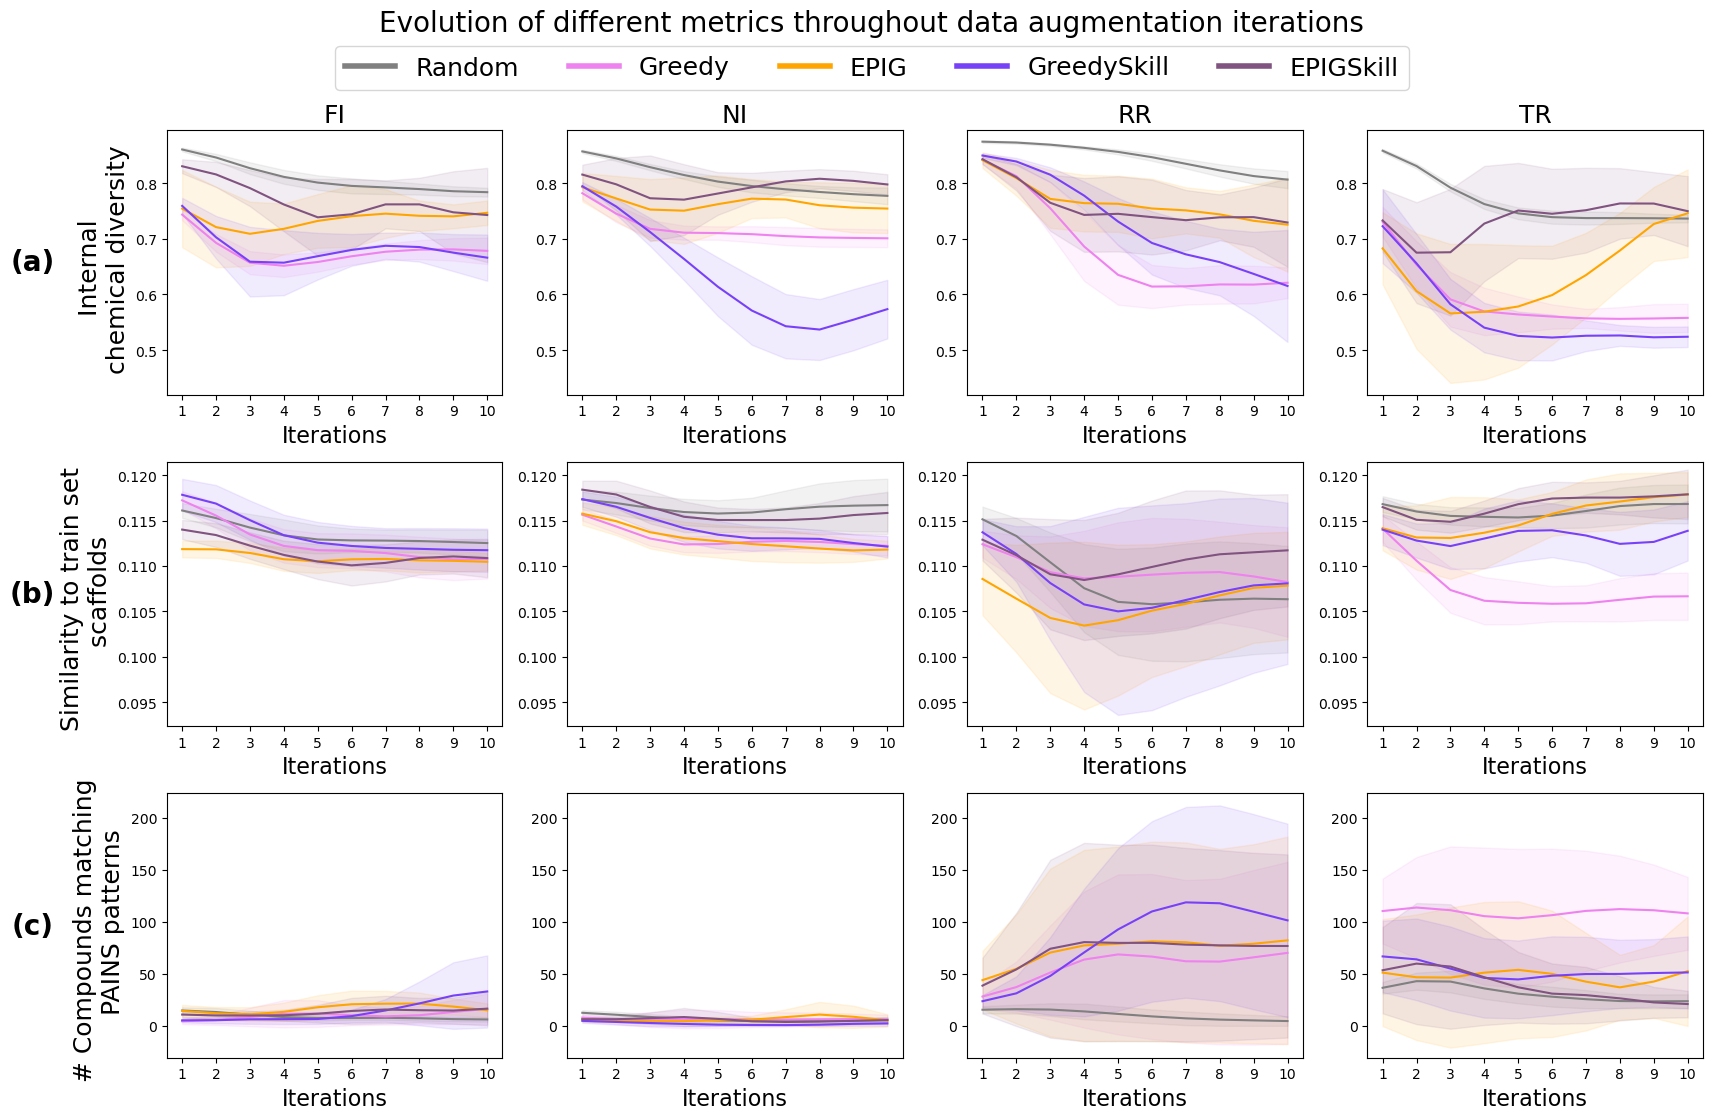

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
# Define your colors for sampling strategies
sampling_colors = {
    "random": "#808080", 
    "greedy": "#ee82ee", 
    "epig": "#FFA500", 
    #"molskill": "#0000ff", 
    "greedyskill": "#7741f7", 
    "epigskill": "#805380"
}
metric_names = {"diversity": "Internal \n chemical diversity", "scaffold_diversity": "Scaffold Diversity", "unique_scaffolds": "Number of unique scaffolds", "pains_yes": "# Compounds matching \n PAINS patterns", "scaffold_similarity": "Similarity to train set \n scaffolds"}

fig, axes = plt.subplots(3, 4, figsize=(18, 12))

# Prepare for legend handles and labels
legend_handles = []
legend_labels = []

for i, task in enumerate(["fluc", "nluc", "redox", "thiol"]):
    #for m, metric in enumerate(["diversity", "scaffold_diversity", "scaffold_similarity", "pains_yes"]):
    for m, metric in enumerate(["diversity", "scaffold_similarity", "pains_yes"]):
        for sampling in ["random", "greedy", "epig", "greedyskill", "epigskill"]:
            all_metric_rep = plot_metric(metric, sampling, task)
            mean_values = [np.mean(v) for v in all_metric_rep]
            smoothed_values = gaussian_filter1d(mean_values, sigma=1)  # Smooth the mean values

            # Compute and smooth the upper and lower bounds for fill_between
            lower_bound = [np.mean(v) - np.std(v) for v in all_metric_rep]
            upper_bound = [np.mean(v) + np.std(v) for v in all_metric_rep]
            smoothed_lower = gaussian_filter1d(lower_bound, sigma=1)  # Smooth lower bound
            smoothed_upper = gaussian_filter1d(upper_bound, sigma=1)  # Smooth upper bound

            # Plot smoothed mean values
            axes[m, i].plot(np.arange(1, 11), smoothed_values, label=sampling, color=sampling_colors[sampling])
            
            # Smooth fill between the smoothed bounds
            axes[m, i].fill_between(np.arange(1, 11), smoothed_lower, smoothed_upper, alpha=0.1, color=sampling_colors[sampling])

            # Add initial mean line
            if metric != "unique_scaffolds":
                initial_mean = np.nanmean(human_analysis[task]["original"][metric]).item()
            else:
                initial_mean = len(human_analysis[task]["original"][metric])

            #axes[m, i].axhline(y=initial_mean, color="red", linestyle="--", label="Initial mean" if i == 0 and m == 0 else "")

            # Set labels and titles
            axes[m, 0].set_ylabel(metric_names[metric], fontsize=18)
            axes[0, i].set_title(tasks_labels[task], fontsize=18)
            axes[m, i].set_xlabel("Iterations", fontsize=16)
            axes[m, i].set_xticks(np.arange(1, 11))

# Add bold text labels for each row
row_labels = ['(a)', '(b)', '(c)']
#row_labels = ['(a)', '(b)', '(c)', '(d)']
for m, label in enumerate(row_labels):
    axes[m, 0].annotate(label, xy=(-0.4, 0.5), xycoords='axes fraction', fontsize=20, fontweight='bold', ha='center', va='center', rotation=0)

# Create the shared legend, only add the initial mean to the legend once
for sampling in sampling_colors:
    handle = plt.Line2D([0], [0], color=sampling_colors[sampling], lw=4, label=strategies_labels[sampling])
    legend_handles.append(handle)

# Calculate and set the same y-axis limits for each row
for m in range(3):  # Iterate over rows (corresponding to metrics in your case)
    # Get all axes in the current row
    y_min, y_max = float('inf'), float('-inf')
    for i in range(4):  # Iterate over columns (corresponding to tasks)
        # Get the current axis
        ax = axes[m, i]
        # Get the data limits for the current axis
        y_min = min(y_min, ax.get_ylim()[0])
        y_max = max(y_max, ax.get_ylim()[1])
    # Set the same y-axis limits for all axes in the current row
    for i in range(4):
        axes[m, i].set_ylim(y_min, y_max)

# Add the initial mean line to the legend
#legend_handles.append(plt.Line2D([0], [0], color='red', linestyle='--', lw=2, label='Initial mean'))

# Place the shared legend
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.53, 0.96), ncol=7, fontsize=18)

plt.suptitle("Evolution of different metrics throughout data augmentation iterations", x=0.53, fontsize=20)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# Save the figure with high DPI
plt.savefig("all_metrics_all_tasks.png", dpi=300, format="png")
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parameters
tasks = ["FI", "NI", "TR", "RR"]
strategies = ["Random", "Greedy", "EPIG", "GreedySkill", "EPIGSkill"]
seeds = range(1, 6)  # Seeds 1 to 5

# Colors for the sampling strategies
sampling_colors = {
    "Random": "#808080", 
    "Greedy": "#ee82ee", 
    "EPIG": "#FFA500", 
    "GreedySkill": "#7741f7",
    "EPIGSkill": "#805380"
}

# Initialize dictionaries to store mean differences and std deviations across seeds
mean_differences = {task: {strategy: [] for strategy in strategies} for task in tasks}
std_differences = {task: {strategy: [] for strategy in strategies} for task in tasks}

# Loop through tasks, strategies, and seeds
for task in tasks:
    # Read the initial dataset and calculate initial active and inactive counts
    initial_df = pd.read_csv(f"trained_dataset/{task}/{task}.csv")
    initial_total = len(initial_df)
    initial_active = initial_df['label'].sum()
    initial_inactive = initial_total - initial_active
    
    for strategy in strategies:
        # Variables to hold cumulative active and inactive counts across iterations
        current_active = initial_active
        current_inactive = initial_inactive
        current_total = initial_total

        mean_across_iterations = []  # Mean of differences across seeds for each iteration
        std_across_iterations = []   # Std of differences across seeds for each iteration

        for i in range(1, 11):  # 10 iterations
            # Collect adjusted proportions for the current iteration across all seeds
            seed_differences = []
            
            for seed in seeds:
                df = pd.read_csv(f"trained_dataset/{task}/{strategy}/rep{seed}/selected_{i}.csv")
                df["label"] = [1 if value > 0.5 else 0 for value in df["interference"].values]
                
                # Update active and inactive counts after adding new compounds from the current iteration
                active = df['label'].sum()
                inactive = len(df) - active
                
                # Calculate the proportion difference for this seed and iteration
                diff = np.abs((current_inactive / current_total) - (current_active / current_total))
                seed_differences.append(diff)
            
            # Compute mean and std for the differences across seeds
            mean_across_iterations.append(np.mean(seed_differences))
            std_across_iterations.append(np.std(seed_differences))

            # Update counts after this iteration
            current_active += sum([df['label'].sum() for seed in seeds]) / len(seeds)
            current_inactive += sum([len(df) - df['label'].sum() for seed in seeds]) / len(seeds)
            current_total += len(df)

        # Store the mean differences and std deviations for this strategy
        mean_differences[task][strategy] = mean_across_iterations
        std_differences[task][strategy] = std_across_iterations

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

# Loop to plot data for each task
for idx, task in enumerate(tasks):
    ax = axes[idx]
    x = np.arange(10)  # 10 iterations
    
    # Loop through each strategy to plot bars with error bars
    for strategy_idx, strategy in enumerate(strategies):
        ax.bar(
            x + (strategy_idx - 2) * 0.15, 
            mean_differences[task][strategy], 
            width=0.15, 
            color=sampling_colors[strategy], 
            edgecolor="black",  # Add black margins to bars
            yerr=std_differences[task][strategy],  # Add standard deviation as error bars
            capsize=3,
            label=strategy if idx == 0 else ""  # Only label legend for the first subplot
        )
    
    ax.set_title(task, fontsize=16)
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([i for i in range(1, 11)], fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Shared y-axis label
fig.text(-0.01, 0.5, 'Mean Proportion Difference (|Interfering - Non-interfering|)', fontsize=14, va='center', rotation='vertical')

fig.legend(
    sampling_colors.keys(), 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.02), 
    ncol=5, 
    title="Sampling Strategies", 
    fontsize=12, 
    title_fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.savefig(f"active_inactive_prop_2x2_std.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'trained_dataset/Fluc/Fluc.csv'

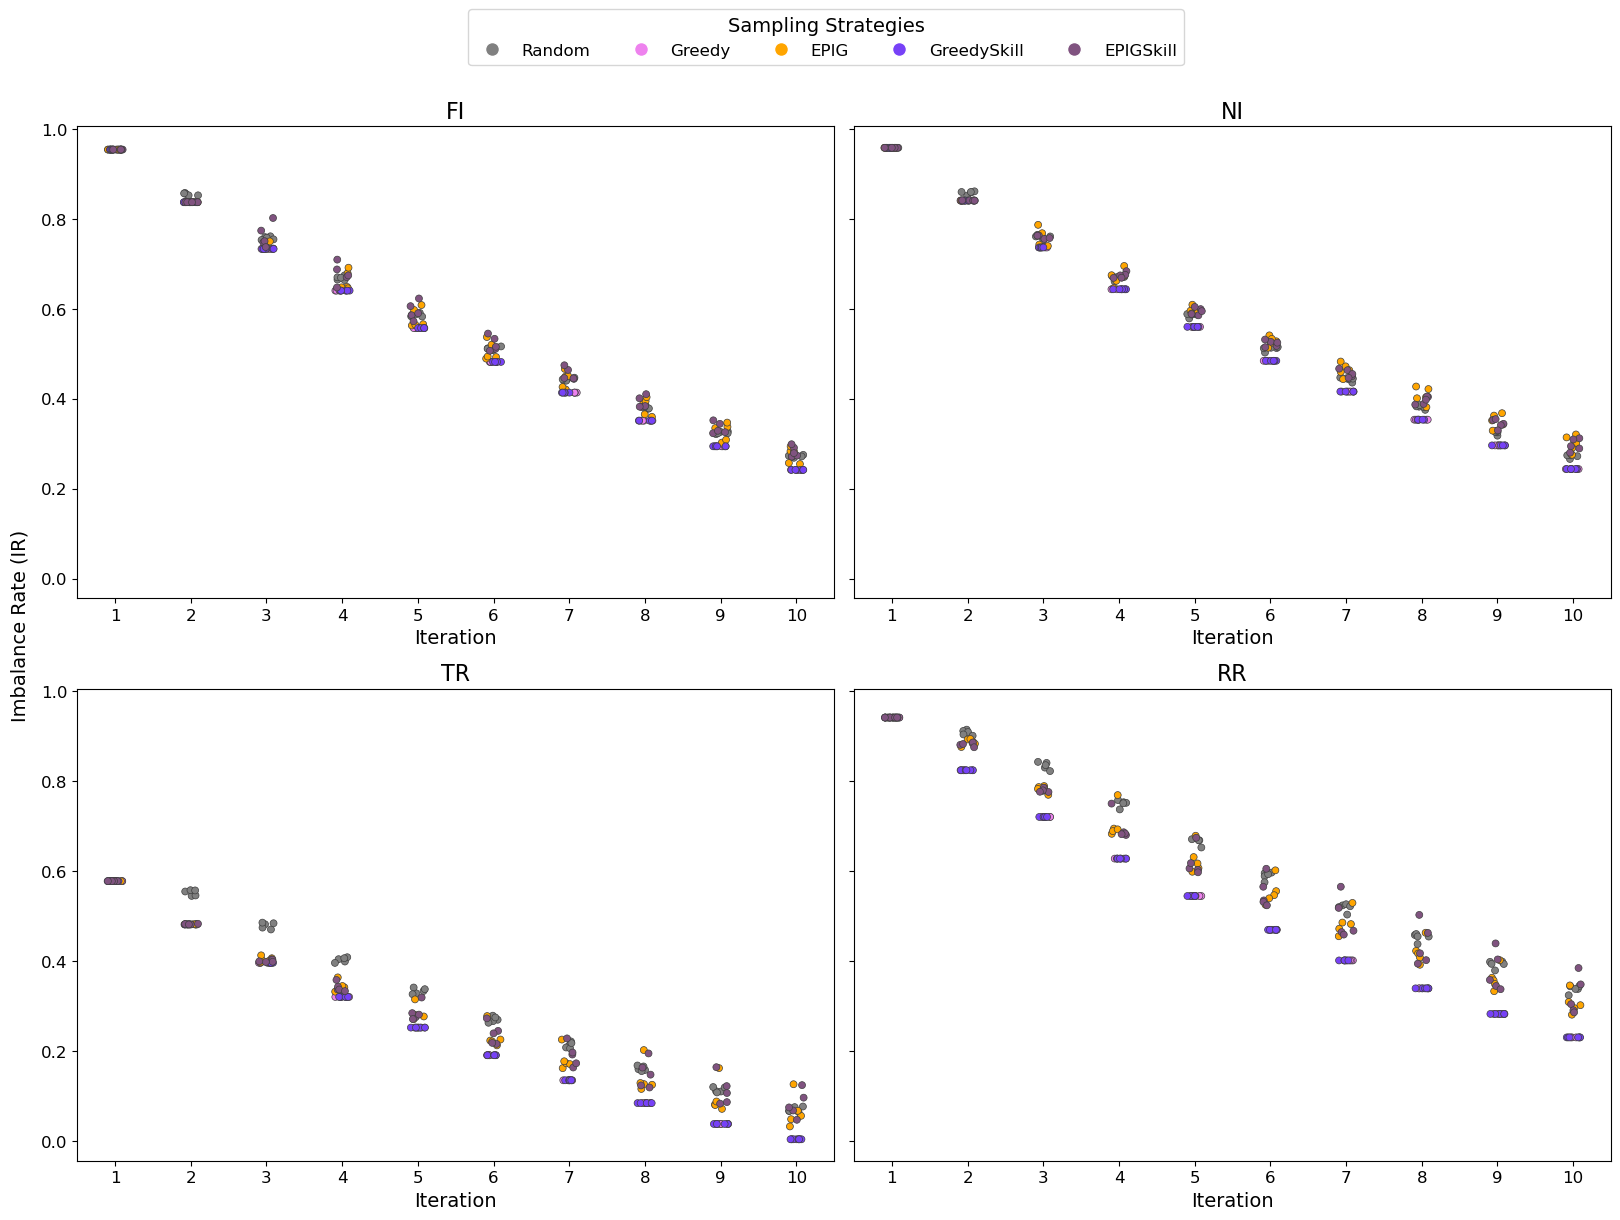

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines

# Parameters
tasks = ["fluc", "nluc", "thiol", "redox"]
tasks_labels = {"fluc": "FI", "nluc": "NI", "thiol": "TR", "redox": "RR"}
strategies = ["random", "greedy", "epig", "greedyskill", "epigskill"]
strategies_labels = {"random": "Random", "greedy": "Greedy", "epig": "EPIG", "greedyskill": "GreedySkill", "epigskill": "EPIGSkill"}
seeds = range(1, 6)  # Seeds 1 to 5

# Colors for the sampling strategies
sampling_colors = {
    "Random": "#808080", 
    "Greedy": "#ee82ee", 
    "EPIG": "#FFA500", 
    "GreedySkill": "#7741f7",
    "EPIGSkill": "#805380"
}

# Initialize a DataFrame to store all data for the strip plot
data = []

# Loop through tasks, strategies, and seeds
for task in tasks:
    # Read the initial dataset and calculate initial active and inactive counts
    initial_df = pd.read_csv(f"trained_dataset/{task}/{task}.csv")
    initial_total = len(initial_df)
    initial_active = initial_df['label'].sum()
    initial_inactive = initial_total - initial_active
    
    for strategy in strategies:
        for seed in seeds:
            # Variables to hold cumulative active and inactive counts for this seed
            current_active = initial_active
            current_inactive = initial_inactive
            current_total = initial_total

            for i in range(1, 11):  # 10 iterations
                # Read the data for this iteration and seed
                df = pd.read_csv(f"trained_dataset/{task}/{strategy}/rep{seed}/selected_{i}.csv")
                df["label"] = [1 if value > 0.5 else 0 for value in df["interference"].values]
                
                # Update active and inactive counts after adding new compounds
                active = df['label'].sum()
                inactive = len(df) - active
                
                # Calculate the proportion difference for this seed and iteration
                diff = np.abs((current_inactive / current_total) - (current_active / current_total))
                
                # Append data for the strip plot
                data.append({
                    "Task": tasks_labels[task],
                    "Strategy": strategies_labels[strategy],
                    "Iteration": i,
                    "Seed": seed,
                    "Proportion Difference": diff
                })
                
                # Update cumulative counts for this seed
                current_active += active
                current_inactive += inactive
                current_total += len(df)

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

# Loop to plot data for each task
for idx, task in enumerate(tasks):
    ax = axes[idx]

    task_name = tasks_labels[task]
    # Filter data for the current task
    task_data = df[df["Task"] == task_name]

    # Create the strip plot using seaborn
    sns.stripplot(
        data=task_data,
        x="Iteration",
        y="Proportion Difference",
        hue="Strategy",
        palette=sampling_colors,
        dodge=False,
        jitter=True,
        linewidth=0.5,
        ax=ax
    )

    # Customize plot appearance
    ax.set_title(tasks_labels[task], fontsize=16)
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel(None)
    ax.set_xticks(range(10))
    ax.set_xticklabels([i for i in range(1, 11)], fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()

# Shared y-axis label
fig.text(-0.01, 0.5, 'Imbalance Rate (IR)', fontsize=14, va='center', rotation='vertical')

# Manually create the legend handles and labels
legend_handles = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10) 
                  for color in sampling_colors.values()]
legend_labels = list(sampling_colors.keys())

# Add a shared legend with custom handles and labels
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=5,
    title="Sampling Strategies",
    fontsize=12,
    title_fontsize=14
)

# Add a shared legend
#fig.legend(
#    labels=sampling_colors.keys(),
#    loc='upper center',
#    bbox_to_anchor=(0.5, 1.02),
#    ncol=5,
#    title="Sampling Strategies",
#    fontsize=12,
#    title_fontsize=14
#)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit everything nicely
plt.savefig("strip_plot_active_inactive_by_seed.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Function to create an image with a molecule and its probability as caption
def create_mol_image_with_caption(smiles, prob, font_size=16):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    mol_img = Draw.MolToImage(mol)
    
    # Convert the molecule image to PIL format and add a caption
    img = Image.new('RGB', (mol_img.width, mol_img.height + 40), 'white')  # Adjusted space for larger text
    img.paste(mol_img, (0, 0))
    draw = ImageDraw.Draw(img)
    
    # Load a custom font with the specified font size
    try:
        font = ImageFont.truetype("arial.ttf", font_size)  # Specify the font and size
    except IOError:
        font = ImageFont.load_default()  # Fallback to default font if custom one isn't found
    
    text = f"Prob: {prob:.2f}"
    
    # Use textbbox (bounding box) to calculate text size
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]  # width of the text
    text_height = bbox[3] - bbox[1]  # height of the text
    
    text_x = (img.width - text_width) // 2
    draw.text((text_x, mol_img.height + 10), text, fill='black', font=font)
    
    return img

# Function to display a grid of molecules with captions
def display_molecules_with_probabilities(df, n_rows=5, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()
    
    for i, (smiles, prob) in enumerate(zip(df['SMILES'], df['interference (raw)'])):
        if i >= n_rows * n_cols:
            break
        img = create_mol_image_with_caption(smiles, prob)
        if img:
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes[i].axis('off')
            axes[i].set_title("Invalid SMILES", fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display the grid
df = pd.read_csv("trained_dataset/nluc/molskill/rep2/selected_4.csv")
display_molecules_with_probabilities(df)